In [1]:
# import data and modules
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, make_union
from sklearn.ensemble import ExtraTreesRegressor
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import SGDClassifier
from tpot.builtins import StackingEstimator

# import feature vectors
X = pd.read_csv('../dft_data/stability/Xdata.csv').iloc[0:, 1:].values
#import target values (critical temperature for complete miscibility of the alloys)
Y = pd.read_csv('../dft_data/stability/tdata.csv').iloc[0:, 1].values

ys = np.concatenate([Y[0:286],Y[558:839]])
yse = np.concatenate([Y[286:558],Y[839:1123]])

fraction of stable TMDC alloys: 0.5093499554764025
fraction of stable MS2 alloys: 0.49206349206349204
fraction of stable MSe2 alloys: 0.5269784172661871


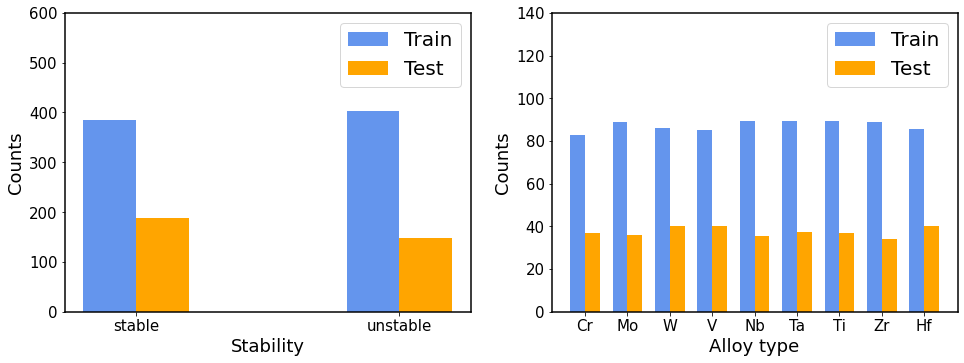

In [2]:
# data preprocessing

# classify dft data
Tcm = 1000 # set 1000K as criteria for stable alloys

Y_log = [1 if y <Tcm else 0 for y in Y]
Y_ls = [1 if y <Tcm else 0 for y in ys]
Y_lse = [1 if y <Tcm else 0 for y in yse]

print("fraction of stable TMDC alloys:",Y_log.count(1)/(Y_log.count(1)+Y_log.count(0)))
print("fraction of stable MS2 alloys:",Y_ls.count(1)/(Y_ls.count(1)+Y_ls.count(0)))
print("fraction of stable MSe2 alloys:",Y_lse.count(1)/(Y_lse.count(1)+Y_lse.count(0)))


import matplotlib.pyplot as plt
import seaborn as sns

def class_element(data):
    atom = {24:0,42:0,74:0,23:0,41:0,73:0,22:0,40:0,72:0}
    for i in range(len(data)):
        s = set(data[i])
        for j in s:
            if j in atom:
                atom[j] += 1
    atom = atom.items()
    keys, values = zip(*atom)
    return keys, values


training_features, testing_features, training_target, testing_target =  \
        train_test_split(X, Y_log, random_state=42,train_size=0.7, test_size=0.3)

labels_1 = ['stable','unstable']
x1 = np.arange(len(labels_1))

key_train,value_train = class_element(training_features)
w_train = np.array(value_train)/2 

key_test,value_test = class_element(testing_features)
w_test = np.array(value_test)/2 

labels_2 = ['Cr','Mo','W','V','Nb','Ta','Ti','Zr','Hf']
x2 = np.arange(len(labels_2))


fig = plt.figure(figsize=(16, 5.5))

ax = fig.add_subplot(1,2,1)
ax.set_xticks(x1)
ax.set_xticklabels(labels_1)
width = 0.2
rects1 = plt.bar(x1 - width/2, [training_target.count(1),training_target.count(0)], width,label='Train',alpha=1,color='cornflowerblue')
rects2 = plt.bar(x1 + width/2, [testing_target.count(1),testing_target.count(0)], width, label='Test',alpha=1,color='orange')
plt.xlabel(r'Stability',fontsize=18)
plt.ylabel(r'Counts',fontsize=18)
#plt.xlim((-1, 9))
plt.ylim((0, 600))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.setp(ax.spines.values(), linewidth=1.5)
plt.legend(loc="best",fontsize='20')

ax = fig.add_subplot(1,2,2)
ax.set_xticks(x2)
ax.set_xticklabels(labels_2)
width = 0.35
rects1 = plt.bar(x2 - width/2, w_train, width,label='Train',alpha=1,color='cornflowerblue')
rects2 = plt.bar(x2 + width/2, w_test, width, label='Test',alpha=1,color='orange')
plt.xlabel(r'Alloy type',fontsize=18)
plt.ylabel(r'Counts',fontsize=18)
#plt.xlim((-1, 9))
plt.ylim((0, 140))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.setp(ax.spines.values(), linewidth=1.5)
plt.legend(loc="best",fontsize='20')
#plt.savefig('data.png', bbox_inches='tight')

plt.show()

In [3]:
# Learning curves 
data_list = np.linspace(100,1123,20)

score_train_ac = []
score_test_ac = []
score_train_f1 = []
score_test_f1 = []

for i in data_list:
    i = int(i)
    x = X[0:i][:]
    y = Y_log[0:i]
    
    training_features, testing_features, training_target, testing_target = \
                train_test_split(x, y, random_state=42,train_size=0.7, test_size=0.3)

    exported_pipeline = make_pipeline(
        StackingEstimator(estimator=SGDClassifier(alpha=0.01, eta0=1.0, fit_intercept=True, l1_ratio=0.5, learning_rate="invscaling", loss="squared_hinge", penalty="elasticnet", power_t=0.5)),
        RFE(estimator=ExtraTreesClassifier(criterion="entropy", max_features=0.65, n_estimators=100), step=0.90),
        RandomForestClassifier(bootstrap=False, criterion="entropy", max_features=0.85, min_samples_leaf=1, min_samples_split=6, n_estimators=100)
    )
    # Fix random state for all the steps in exported pipeline
    set_param_recursive(exported_pipeline.steps, 'random_state', 42)

    exported_pipeline.fit(training_features, training_target)
    scores_ac = cross_val_score(exported_pipeline, training_features, training_target, scoring="accuracy", cv=10)
    scores_f1 = cross_val_score(exported_pipeline, training_features, training_target, scoring="f1", cv=10)
    score_train_ac.append((scores_ac.mean()))
    score_train_f1.append((scores_f1.mean()))
    
    scores1_ac = cross_val_score(exported_pipeline, testing_features, testing_target, scoring="accuracy", cv=10)
    scores1_f1 = cross_val_score(exported_pipeline, testing_features, testing_target, scoring="f1", cv=10)
    score_test_ac.append((scores1_ac.mean()))
    score_test_f1.append((scores1_f1.mean()))


Test Accuracy:0.8930481283422459
Test F1:0.908270207743892
Train Accuracy:0.9261441090555016
Train F1:0.9258759879001127


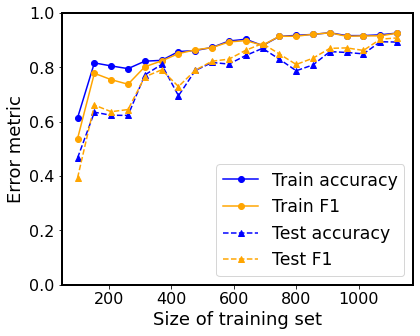

In [9]:
fig = plt.figure(figsize=(6.3, 5))

ax = fig.add_subplot(1,1,1)

plt.plot(data_list[0:], score_train_ac[0:], linestyle='-', linewidth=1.5, marker='o', label='Train accuracy',color='blue')
plt.plot(data_list[0:], score_train_f1[0:], linestyle='-', linewidth=1.5, marker='o', label='Train F1',color='orange')

plt.plot(data_list[0:], score_test_ac[0:], linestyle='--', linewidth=1.5, marker='^', label='Test accuracy',color='blue')
plt.plot(data_list[0:], score_test_f1[0:], linestyle='--', linewidth=1.5, marker='^', label='Test F1',color='orange')

plt.xlabel("Size of training set",fontsize=18)
plt.ylabel("Error metric",fontsize=18)
plt.ylim((0, 1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.setp(ax.spines.values(), linewidth=2)
plt.legend(loc="best",fontsize='xx-large',ncol=1)
#plt.savefig('learning.png', bbox_inches='tight')

print("Test Accuracy:{}".format(score_test_ac[-1]))
print("Test F1:{}".format(score_test_f1[-1]))
print("Train Accuracy:{}".format(score_train_ac[-1]))
print("Train F1:{}".format(score_train_f1[-1]))

plt.show()

In [ ]:
import joblib

#save Model
joblib.dump(exported_pipeline, 'model_stability.pkl')
